<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

# Building A Multi-Arm Bandit Split Test

Week 11 | Lab 2.1

---

In this lab you will be building a multi-arm bandit split test from scratch. Don't be intimidated though, it's not as difficult as it sounds. By the end you'll understand it's strengths and weaknesses as compared to a standard split test setup.

---

## Revisiting the standard split test

The standard split test format follows these steps:

1. Create versions of a piece of your product (or any simple hypothesis-testable thing) and assign these versions to "arms", typically denoted by capital letters.
- Determine a metric that you will test on (user conversions is a popular one, clickthroughs, etc.)
- Decide how new users will proportionally be divided randomly into the arms over the course of the split test.
- Determine a threshold of significance below which an arm with the best performance will be "winnered"/chosen as the new version.
- Decide upon a fixed amount of time that the test will run based on the number of subjects needed. This can be done with a [power analysis](https://signalvnoise.com/posts/3004-ab-testing-tech-note-determining-sample-size) which we haven't done but is discussed below.
- Check the results and determine a winner. If no arm reaches the specified significance then keep the control, aka original arm.

We will be running a standard split test as well as a multi-arm bandit to show the differences, so the process is important to know! Below you will set up your variables for the standard split test which will also apply to the bandit.

---

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

### 1.1. Setup the tests with the information and parameters required

We are going to be running a split test with 4 arms: A, B, C, and D. Arm A is your control/original arm. Below, set up the following information we know and parameters we would like to use for our split tests in code:

1. We already know some conversion parameters for our control arm A. There have been **1050 converted users** and **12120 users lost** so far.
- Users have been coming in at an average rate of **100 users per hour**.
- For an arm to be "winnered", we are requiring an **alpha = 0.01**, which means the signficance (p-value) of an arm's rate being greater than the control arm needs to be less than 0.01. 
    - The alpha parameter corresponds to [our threshold for Type I errors](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors), or the rejection of the null hypothesis when the null hypothesis is in fact true.
- We also want to control the Type II error, or the rejection of the _alternative hypothesis when in fact the alternative hypothesis is true._ This is denoted as "beta" and is the Type II error sibling of the alpha Type I error parameter. We decide **beta = 0.05**. The **power** of the test is 1 - beta.
    - People usually care less about false negatives than false positives, which is why we are keeping beta higher than alpha (this will let us estimate fewer required subjects for our test).
- Decide on a desired **effect size** required to select a new arm, which is estimated by the _difference in proportions, or rates of our arms_. I have provided a function below to help you calculate the effect size for the difference between two rates from statsmodels. We want our **difference between conversion rates in arms to be at least 0.02**, or tow percent more conversions.
- We have decided that 40% of our incoming users will be directed to the A control arm and the remaining arms will be divided evenly among incoming users (15%).

---

In [50]:
import statsmodels.stats.api as sms

# Calculate effect size from difference in proportions, which in this case is conversion rates.
def calculate_effect_size(control_rate, desired_increase):
    desired_rate = control_rate + desired_increase
    # statsmodels function gives us the effect size in standard deviation differences from
    # the normal distribution (how many standard deviations of conversion more do we want.)
    effect_size = sms.proportion_effectsize(desired_rate, control_rate)
    return effect_size

A_c = 1050.
A_l = 12120.
A_r = A_c / (A_c + A_l)
print A_r
hr_r = 100
day_r = hr_r*24
alpha = 0.01
beta = 0.05
power = 1 - beta
desired_increase = 0.02
effect_size = calculate_effect_size(A_r, desired_increase)
print effect_size
A_user_prop = 0.6
BCD_user_prop = 0.2

0.0797266514806
0.0700846516149


In [51]:
(A_r + 0.02) / A_r

1.250857142857143

---

### 1.2. Setup the hidden true rates of conversion for the 4 arms. (Done for you).

The functions below take a number of users and return whether they converted or not (1 or 0). This is determined by a binomial random variable with the true rates of conversion for each. We have the true values here, but in a split test you obviously don't have the true values and are estimating them with some degree of confidence. We already have an idea of what arm A's conversion rate is since we have been collecting conversion data for it. 


In [157]:
A_true_r = 0.091
B_true_r = 0.089
C_true_r = 0.092
D_true_r = 0.093

def A_convert(users=1):
    return np.random.binomial(1, A_true_r, size=users)

def B_convert(users=1):
    return np.random.binomial(1, B_true_r, size=users)

def C_convert(users=1):
    return np.random.binomial(1, C_true_r, size=users)

def D_convert(users=1):
    return np.random.binomial(1, D_true_r, size=users)

---

## Calculating the number of users (and days) required for the split test

This is something I did not cover yesterday but is important, obviously. Using the significance (alpha) and the power (1 - beta) we can calculate the number of users we need. Following that, we can calculate the number of days given our rate of user visits to the page.

For more information see these useful pages:

https://signalvnoise.com/posts/3004-ab-testing-tech-note-determining-sample-size

https://en.wikipedia.org/wiki/Type_I_and_type_II_errors

https://www.andrews.edu/~calkins/math/edrm611/edrm11.htm#SAMS

https://help.optimizely.com/Analyze_Results/How_long_to_run_a_test#minimum

---

### 2.1. Use the function below to calculate the number of users required for the test

I am not requiring you to look up and figure out on your own how to do the power analysis, but am giving you the python function to do it below. Determine the estimated number of users and then the estimated number of days and hours required for our split test to run with our alpha and beta thresholds.

**IMPORTANT:** The number of subjects you get out of the power analysis is **the number of users required for each arm!**. Because we are putting fewer users into the experimental arms, this means that you will have to figure out the number of users required in total given that the users calculated from this power analysis is only 15% of them.

In [158]:
# Function to calculate the number of users from alpha and beta parameters.
def calculate_n_users(desired_effect_size, power, alpha):
    
    # Don't worry about the ratio - it has to do with the fact that our 
    # effect size is relative to the the normal distribution.
    return np.ceil(sms.NormalIndPower().solve_power(desired_effect_size, 
                                                    power=power, 
                                                    alpha=alpha, 
                                                    ratio=1))
    
    
est_req_users = np.ceil(calculate_n_users(effect_size, power, alpha) * (0.4 / 0.2))*4
print est_req_users
est_days_req = np.ceil(est_req_users/day_r)
est_hrs_req = np.ceil(est_req_users/hr_r)
print est_days_req, est_hrs_req

58032.0
25.0 581.0


---

## Running the standard split test

Now that you have the number of days required to run the test, you will emulate a standard split test using the user conversion generating functions above. 


### 3.1 Set up a DataFrame below for the standard split test, calculating the number of users converted and lost per arm, per day 

Calculate the rate as well.

In [159]:
def calculate_standard_split_test(d):
    arm = d.arm.values[0]
    if arm == 'A':
        users = A_convert(users=24*40)
    elif arm == 'B':
        users = B_convert(users=24*15)
    elif arm == 'C':
        users = C_convert(users=24*15)
    elif arm == 'D':
        users = D_convert(users=24*15)
    converted = np.sum(users)
    lost = len(users) - converted
    d['conv'] = converted
    d['lost'] = lost
    d['rate'] = float(converted)/(converted+lost)
    return d

st = []
for arm in ['A','B','C','D']:
    st_arm = pd.DataFrame()
    st_arm['day'] = np.arange(est_days_req)
    st_arm['arm'] = arm
    st.append(st_arm)
    
st = pd.concat(st, axis=0)
st = st.groupby(['arm','day']).apply(calculate_standard_split_test).reset_index(drop=True)
st.head()

print st.shape



(100, 5)


---

### 3.2. Calculate the significance of the different conversion rates for arms at the final day using a linear regression.

We can actually use linear regression to see if there are significant differences in our experimental arm from our control arm. 

Using `smf.ols`, predict the rate per arm from categorical (dummy coded) variabes for the arms. [You can include the formula in the function, so no need for patsy. NOTE: do not include the -1 term for statsmodels.](http://statsmodels.sourceforge.net/devel/index.html) Include the total number of users per hour as an additional regressor to control for differences in user count per arm.

In [160]:
import statsmodels.formula.api as smf

st['user_total'] = st.conv + st.lost
st_results = smf.ols('rate ~ C(arm)', data=st).fit()
print st_results.summary()


                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.928
Date:                Tue, 21 Jun 2016   Prob (F-statistic):             0.0376
Time:                        11:28:07   Log-Likelihood:                 295.39
No. Observations:                 100   AIC:                            -582.8
Df Residuals:                      96   BIC:                            -572.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.0892      0.003     34.644      

---

### 3.3. Calculate the significance with an ANOVA

You can do the same thing as above in a simpler way with the ANOVA f-test. This is just a generalization of the t-test for multiple group means (3 or more). If the p-value is below your significance threshold, it indicates that the null hypothesis that all the means are in fact equal can be rejected.

Perform this with the `stats.f_oneway()` function from scipy.

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

In [161]:
Ar = st[st.arm == 'A'].rate.values
Br = st[st.arm == 'B'].rate.values
Cr = st[st.arm == 'C'].rate.values
Dr = st[st.arm == 'D'].rate.values

anova_test = stats.f_oneway(Ar, Br, Cr, Dr)
print anova_test

F_onewayResult(statistic=2.9277049358180616, pvalue=0.037613768110830136)


--

## 4. Constructing the multi-arm bandit split test. 

Now we will construct a split test using the multi arm bandit!

The multi-arm bandit procedure is actually quite simple, except perhaps for understanding why the beta distribution is used. I will explain this, however. The procedure is as follows:

1. Calculate your estimated rates for each arm. In our case, we can use the known rates for the A arm from previous conversions for the initial arm A distribution.
- These rates, or rather the number of conversions and number of losses, are used to construct **beta distributions** that define the probability density function of each arm.
    - What does this mean? Recall that these split test arms are just a **binomial or bernoulli process**, in which "coin flips" are performed with a bias/weighting, or probability. Our arms each have a "true" probability of conversion, which defines the bias.
    - If you imagine a chart with an x-axis that goes from 0 to 1000, where x is user conversions, the y-axis in this case is the probability that you get that many conversions out of 1000. These are all different outcomes of 1000 "coin flip" instances with that true bias. The distribution over these probabilities is the beta distribution, and so is intrinsically related to the binomial process (which is conversions with probabilities per arm in our case).
- When assigning a user to an arm, the process is no longer random according to pre-defined proportions. Instead, **we draw a random number from each arm's beta distribution. The user is assigned to the arm with the highest random value.**
- At pre-specified intervals, the beta distributions are updated with the cumulative conversions and losses per arm. This means that as time passes, the split test is adjusting so that the better arms are getting more of the users! The multi-arm bandit "automatically" converges on the best arm for your metric.


---

### 4.1. Create a function that will draw a random number from a beta distribution with specified "wins" and "losses"

In your case, the wins are conversions and the losses are user losses. The `np.random.beta()` function will take an `a` corresponding to wins and `b` corresponding to losses.

Note that you actually need to add 1 to both a and b, essentially because a 0,0 beta distribution is undefined.

In [162]:
def beta_rand(conversions, losses, users):
    return np.random.beta(conversions+1, losses+1, size=users)

---

### 4.2. Create a function that will assign a user (or users) to an arm based on the process of drawing random numbers from each arm's beta distribution

So, to reiterate:

    for each user:
        A_p = np.random.beta(A_converted+1, A_lost+1)
        B_p = np.random.beta(B_converted+1, B_lost+1)
        C_p = np.random.beta(C_converted+1, C_lost+1)
        D_p = np.random.beta(D_converted+1, D_lost+1)
        
        user is assigned to arm with highest *_p value


In [163]:
def assign_user(arms):
    max_p = 0.
    max_arm = 'A'
    
    for arm in ['A','B','C','D']:
        p = beta_rand(arms[arm]['wins'], arms[arm]['losses'], 1)
        if p > max_p:
            max_p = p
            max_arm = arm
            
    return max_arm
    

---

### 4.3. Construct and run the multi-arm bandit split test

You will again keep track of the number of users converting and not converting per arm. **This time, track the number of conversions per hour rather than day.**

Requirements/setup of the split test:

1. Update the beta distributions **every 6 hours** with the new cumulative conversions and losses per arm.
    - Arm A will start with its previously observed conversions and losses, arms B, C, and D will start with `np.random.beta(1,1)`
2. For each user, perform the beta distribution weighted probability selection for the arms and assign the user to that arm.
3. Once a user is assigned to an arm, you can calculate whether they converted or not using the "true" rate functions we used for the standard split test above.
4. You will be calculating **cumulative conversions/losses from the beginning of the test** rather than just the numbers for that hour.
    - This may be easiest to do at each 6-hour iteration when you need to update the number of cumulative conversions and losses for each arm that you will use for the next 6-hour block of arm assignments.
5. Note that you may want to keep track of day (as a float) to make the next plotting segment easier.

In [164]:
[1,2,3,4,5,6][0:5]

[1, 2, 3, 4, 5]

In [168]:
hours = np.tile(np.arange(1, est_hrs_req+1), 100)
hours.sort()
user_id = np.arange(1, len(hours)+1)

mab = pd.DataFrame()
mab['hour'] = hours
mab['user_id'] = user_id
mab['arm'] = 'A'
mab['converted'] = 0
mab['lost'] = 0
print mab.shape

arms_dict = {k:{'wins':0., 'losses':0.} for k in ['A','B','C','D']}
arms_dict['A']['wins'] = A_c
arms_dict['A']['losses'] = A_l

print arms_dict

next_hour = 12

for i in range(0, mab.shape[0]):
    
    if (i+1 < mab.shape[0]) and (mab.hour.values[i+1] % next_hour == 0):
        print 'Recalculating arm betas...'
        arms = mab.arm.values[0:i]
        conv = mab.converted.values[0:i]
        lost = mab.lost.values[0:i]
        for arm in ['A','B','C','D']:
            cum_conv = np.sum([c for c, a in zip(conv, arms) if a == arm])
            cum_loss = np.sum([l for l, a in zip(lost, arms) if a == arm])
            arms_dict[arm]['wins'] = cum_conv
            arms_dict[arm]['losses'] = cum_loss
    
        next_hour += 12
        print arms_dict
            
    user_arm = assign_user(arms_dict)
    
    if user_arm == 'A':
        converted = A_convert()
    elif user_arm == 'B':
        converted = B_convert()
    elif user_arm == 'C':
        converted = C_convert()
    else:
        converted = D_convert()
        
    mab.ix[i, 'arm'] = user_arm
    mab.ix[i, 'converted'] = converted
    if converted == 1:
        mab.ix[i, 'lost'] = 0
    else:
        mab.ix[i, 'lost'] = 1
    

(58100, 5)
{'A': {'wins': 1050.0, 'losses': 12120.0}, 'C': {'wins': 0.0, 'losses': 0.0}, 'B': {'wins': 0.0, 'losses': 0.0}, 'D': {'wins': 0.0, 'losses': 0.0}}
Recalculating arm betas...
{'A': {'wins': 0.0, 'losses': 0.0}, 'C': {'wins': 33, 'losses': 344}, 'B': {'wins': 40, 'losses': 331}, 'D': {'wins': 31, 'losses': 320}}
Recalculating arm betas...
{'A': {'wins': 102, 'losses': 966}, 'C': {'wins': 36, 'losses': 355}, 'B': {'wins': 52, 'losses': 418}, 'D': {'wins': 33, 'losses': 337}}
Recalculating arm betas...
{'A': {'wins': 112, 'losses': 1073}, 'C': {'wins': 61, 'losses': 492}, 'B': {'wins': 116, 'losses': 1138}, 'D': {'wins': 45, 'losses': 462}}
Recalculating arm betas...
{'A': {'wins': 127, 'losses': 1183}, 'C': {'wins': 136, 'losses': 1319}, 'B': {'wins': 124, 'losses': 1205}, 'D': {'wins': 61, 'losses': 544}}
Recalculating arm betas...
{'A': {'wins': 164, 'losses': 1446}, 'C': {'wins': 148, 'losses': 1445}, 'B': {'wins': 138, 'losses': 1351}, 'D': {'wins': 108, 'losses': 1099}}
R

### 4.4. Plot the beta distributions at different days.

Plotting out the beta distributions for the arms as they change will show you how the multi-arm bandit changes the probability of assignment to each arm.

Plot the beta distributions for each arm on the same plot for:

    day 1
    day 3
    day 5
    day 10
    day 21
    
To plot the distributions you can use this process:

1. Generate a decent range of x-values for the x-axis between 0 and 1 with `np.linspace()`
2. Use `stats.beta.pdf(x, a, b)` to get the y-axis values.
    - The x argument is your x-axis values
    - The a argument is your cumulative conversions at that time point + 1
    - The b argument is your cumulative losses at that time point + 1

In [169]:
mab['day'] = mab.hour / 24.

In [170]:

def cumsum_by_arm(mab_sub):
    mab_sub['conv_cs'] = np.cumsum(mab_sub.converted)
    mab_sub['lost_cs'] = np.cumsum(mab_sub.lost)
    return mab_sub
    
mab_cs = mab.groupby('arm').apply(cumsum_by_arm).reset_index(drop=True)

mab_cs05 = mab_cs[mab_cs.day < 0.6]
mab_cs1 = mab_cs[mab_cs.day < 2]
mab_cs3 = mab_cs[mab_cs.day < 4]
mab_cs5 = mab_cs[mab_cs.day < 6]
mab_cs10 = mab_cs[mab_cs.day < 11]

def last_by_arm(sub):
    return sub.iloc[-1,:]

mab_cs05 = mab_cs05.groupby('arm').apply(last_by_arm).reset_index(drop=True)
mab_cs1 = mab_cs1.groupby('arm').apply(last_by_arm).reset_index(drop=True)
mab_cs3 = mab_cs3.groupby('arm').apply(last_by_arm).reset_index(drop=True)
mab_cs5 = mab_cs5.groupby('arm').apply(last_by_arm).reset_index(drop=True)
mab_cs10 = mab_cs10.groupby('arm').apply(last_by_arm).reset_index(drop=True)

In [171]:
mab_cs1

,hour,user_id,arm,converted,lost,day,conv_cs,lost_cs
0,47.0,4700,A,1,0,1.958333,128,1183
1,47.0,4657,B,0,1,1.958333,124,1205
2,47.0,4699,C,1,0,1.958333,136,1319
3,47.0,4690,D,0,1,1.958333,61,544


In [177]:
def mab_plotter(df):

    fig = plt.figure(figsize=(14,7))
    ax = fig.gca()
    x = np.linspace(0,1,1000)
    
    apdf = stats.beta.pdf(x, df[df.arm == 'A'].conv_cs.values[0], 
                          df[df.arm == 'A'].lost_cs.values[0])
    bpdf = stats.beta.pdf(x, df[df.arm == 'B'].conv_cs.values[0], 
                          df[df.arm == 'B'].lost_cs.values[0])
    cpdf = stats.beta.pdf(x, df[df.arm == 'C'].conv_cs.values[0], 
                          df[df.arm == 'C'].lost_cs.values[0])
    dpdf = stats.beta.pdf(x, df[df.arm == 'D'].conv_cs.values[0], 
                          df[df.arm == 'D'].lost_cs.values[0])
    
    ax.plot(x, apdf, lw=3, c='darkred', label='A')
    ax.plot(x, bpdf, lw=3, c='steelblue', label='B')
    ax.plot(x, cpdf, lw=3, c='teal', label='C')
    ax.plot(x, dpdf, lw=3, c='gold', label='D')
    
    ax.set_xlim([0.05, 0.15])
    plt.legend()
    
    plt.show()
    
    
    

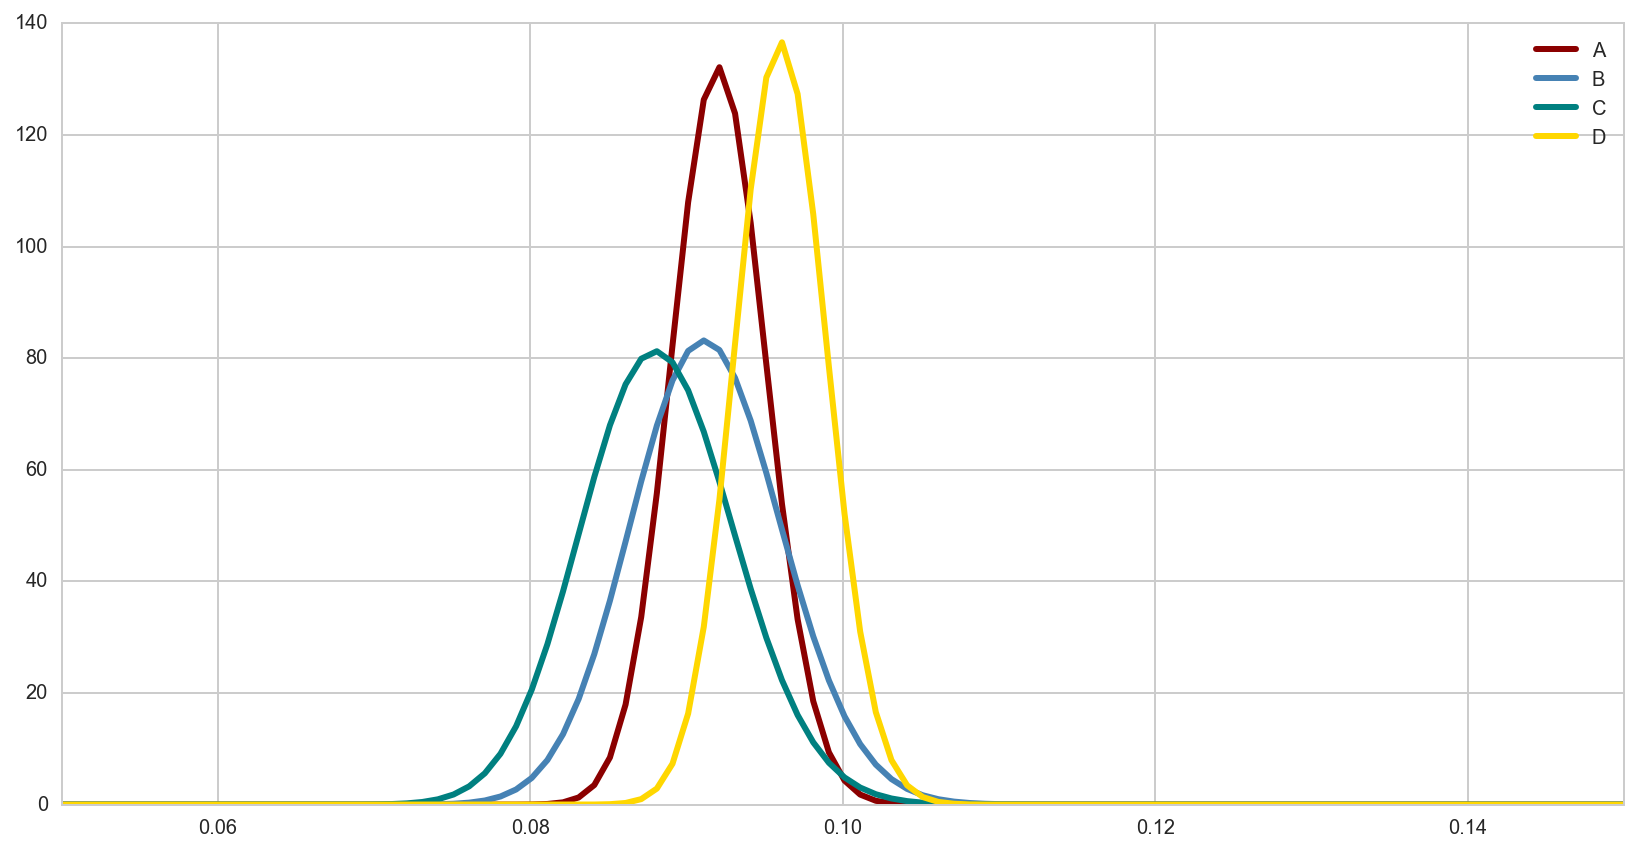

In [182]:
mab_plotter(mab_cs10)

---

## Pros and cons to multi-arm bandit

The multi-arm bandit is cool, but like everything in statistics has pros and cons as compared to other methods.

---

### 5.1. Calculate the total number of conversions and losses (and rate) for the standard split test and multi-arm bandit split test at the final day

Which split test version achieved a greater conversion rate over that period?

---

### 5.2. Winner the best arm from the standard split test and calculate the new cumulative conversions and losses out to day 50.

---

### 5.3. Continue the multi-arm bandit process out to day 50 as well. Compare the standard split test to the multi-arm bandit at this time point.